<div style="text-align:right;">Justine Charrel - Master 1 Internship</div>

In [15]:
import pandas as pd 
from datetime import datetime,date
import datetime
import numpy as np
import xarray as xr
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import re
import string

### Load Co-located ERA5 data (+ TOPAZ reanalysis)

In [16]:
era5_sfs60 = pd.read_csv('/lustre/storeB/users/justinec/master_internship/data/Met_city/mosasfs_level2v3_60_ERA5.csv')
for i in range(np.max(np.shape(era5_sfs60))):
    era5_sfs60.loc[i, 'datetime'] = datetime.datetime.strptime(era5_sfs60.loc[i, 'datetime'], '%Y-%m-%d %H:%M:%S')

### Load MOSAiC data and filter to hourly data corresponding to the ERA5 data

In [17]:
# Run the first time
#mosasfs60met = xr.open_dataset("/lustre/storeB/users/maltem/nowwind/MOSAiC/mosseb.metcity.level2v3.10min.all.nc" 
#mosasfs60met_1h = mosasfs60met.resample(time="1H").interpolate("linear") 
#mosasfs60met_1h.to_netcdf("/lustre/storeB/users/justinec/master_internship/data/Met_city/mosasfs60met.level2v3.1h.all.nc")

In [18]:
mosasfs60met_1h = xr.open_dataset("/lustre/storeB/users/justinec/master_internship/data/Met_city/mosasfs60met.level2v3.1h.all.nc")

In [19]:
mosasfs60met_1h.down_short_hemisp[5000:6152] = np.nan
mosasfs60met_1h.down_short_hemisp[6921:7573] = np.nan
mosasfs60met_1h.up_short_hemisp[5000:6152] = np.nan
mosasfs60met_1h.up_short_hemisp[6921:7573] = np.nan

### Load sea ice Data from OSISAF and CryoSat-2-SMOS

In [20]:
path_sea_ice = '/lustre/storeB/users/justinec/master_internship/data/SEA_ICE/'
df_sea_ice = pd.read_csv(path_sea_ice+'Sea_ice_data_from_satellites.txt', sep='\t')

def format_date(x):
    return datetime.datetime.strptime(str(x), '%Y%m%d%H%M%S')

df_sea_ice['date'] = df_sea_ice['date'].map(format_date)
df_sea_ice = df_sea_ice.set_index('date')

#sea_ice concentration_osi is from the .nc file of osi-saf
#sea_ice_concentration_cryosat-smos is from the .nc file of cryosat2-smos but from osi-saf 
#sea_ice_thickness is from the.nc file of cryosat2-smos so from cryosat-smos product
#sea_ice_type is from the .nc file of cryosat2-smos but from osi-saf

### Harmonize time-axis and set time range

In [21]:
tstart=pd.Timestamp('2019-10-1'); tend=pd.Timestamp('2020-9-30')

mosasfs60met_1h = mosasfs60met_1h.sel(time=slice(tstart,tend))
df = era5_sfs60; df = df.set_index(['datetime']); df = df.loc[tstart:tend]; era5_sfs60  = df.reset_index() 

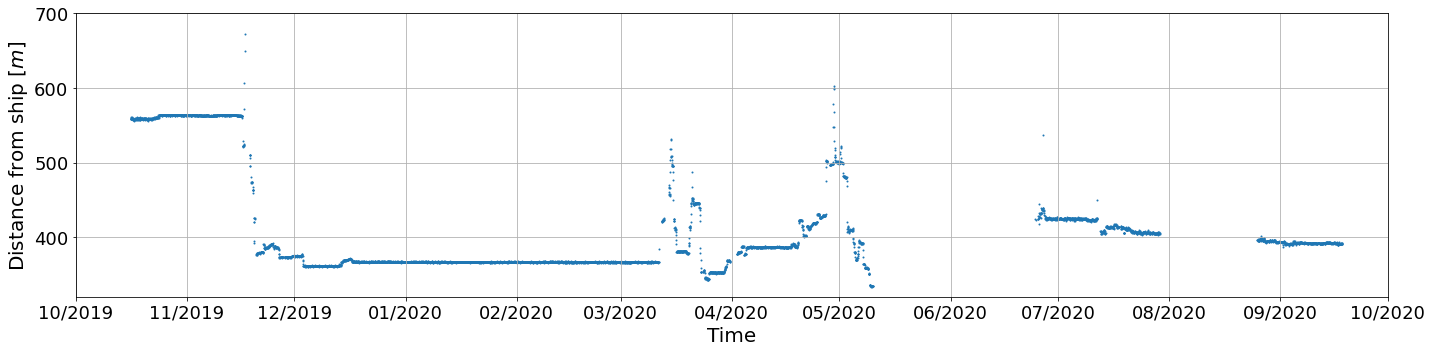

In [22]:
parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
                  'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
plt.scatter(mosasfs60met_1h.time,mosasfs60met_1h.ship_distance, s=1)
ax.set_xlim([datetime.date(2019, 10, 1), datetime.date(2020, 10, 1)])
ax.set_yticks([400,500,600,700])
ax.set_ylim(320,700)
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%Y'))
ax.xaxis.set_major_locator(dates.MonthLocator())
plt.xlabel('Time')
plt.grid()
plt.ylabel('Distance from ship [$m$]')
fig.tight_layout()
path_fig = '/lustre/storeB/users/justinec/master_internship/figures/'
plt.savefig(path_fig+'MetCity_distance.png',dpi=300, facecolor='white', transparent=False)

In [23]:
for i in range(len(era5_sfs60.istl)):
    if isinstance(era5_sfs60.istl[i], float) and np.isnan(era5_sfs60.istl[i]) :
        era5_sfs60.loc[i, 'istl'] = np.nan
    else:
        match = re.findall(r'\[(\d+\.?\d*)\]', era5_sfs60.loc[i, 'istl'])
        if match:
            era5_sfs60.loc[i, 'istl'] = float(match[0])

In [24]:
#outlier values in u MOSAiC
for i in range (0,len(mosasfs60met_1h.wspd_u_mean_10m)) :
    if mosasfs60met_1h.wspd_u_mean_10m[i] < -20 :
        mosasfs60met_1h.wspd_u_mean_10m[i] = np.nan

In [25]:
era5_sfs60_daily_mean = era5_sfs60.groupby(pd.Grouper(key='datetime', freq='D')).mean()

In [26]:
mosasfs60met_1h_daily_mean = mosasfs60met_1h.resample(time='D').mean()

(18367.0, 18372.0)

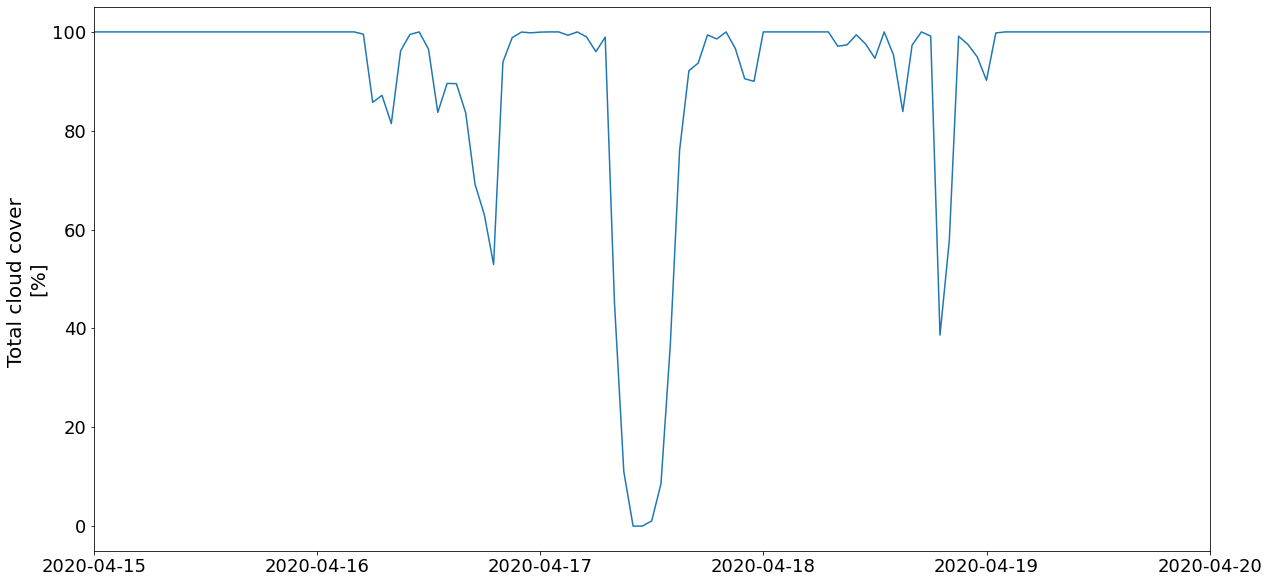

In [27]:
plt.figure(figsize=(20,10))
plt.plot(era5_sfs60.datetime, era5_sfs60.tcc*100,'-',label='ERA5',color='C0')
plt.ylabel('Total cloud cover \n[%]')
plt.xlim([datetime.date(2020, 4, 15), datetime.date(2020, 4, 20)])

In [28]:
era5_wspd = []
mosaic_wspd = []
for i in range(0, len(era5_sfs60.u10m)) :
    era5_wspd.append(np.sqrt(era5_sfs60.u10m[i]**2+era5_sfs60.v10m[i]**2))
    mosaic_wspd.append(np.sqrt(mosasfs60met_1h.wspd_u_mean_10m.to_numpy()[i]**2+mosasfs60met_1h.wspd_v_mean_10m.to_numpy()[i]**2))

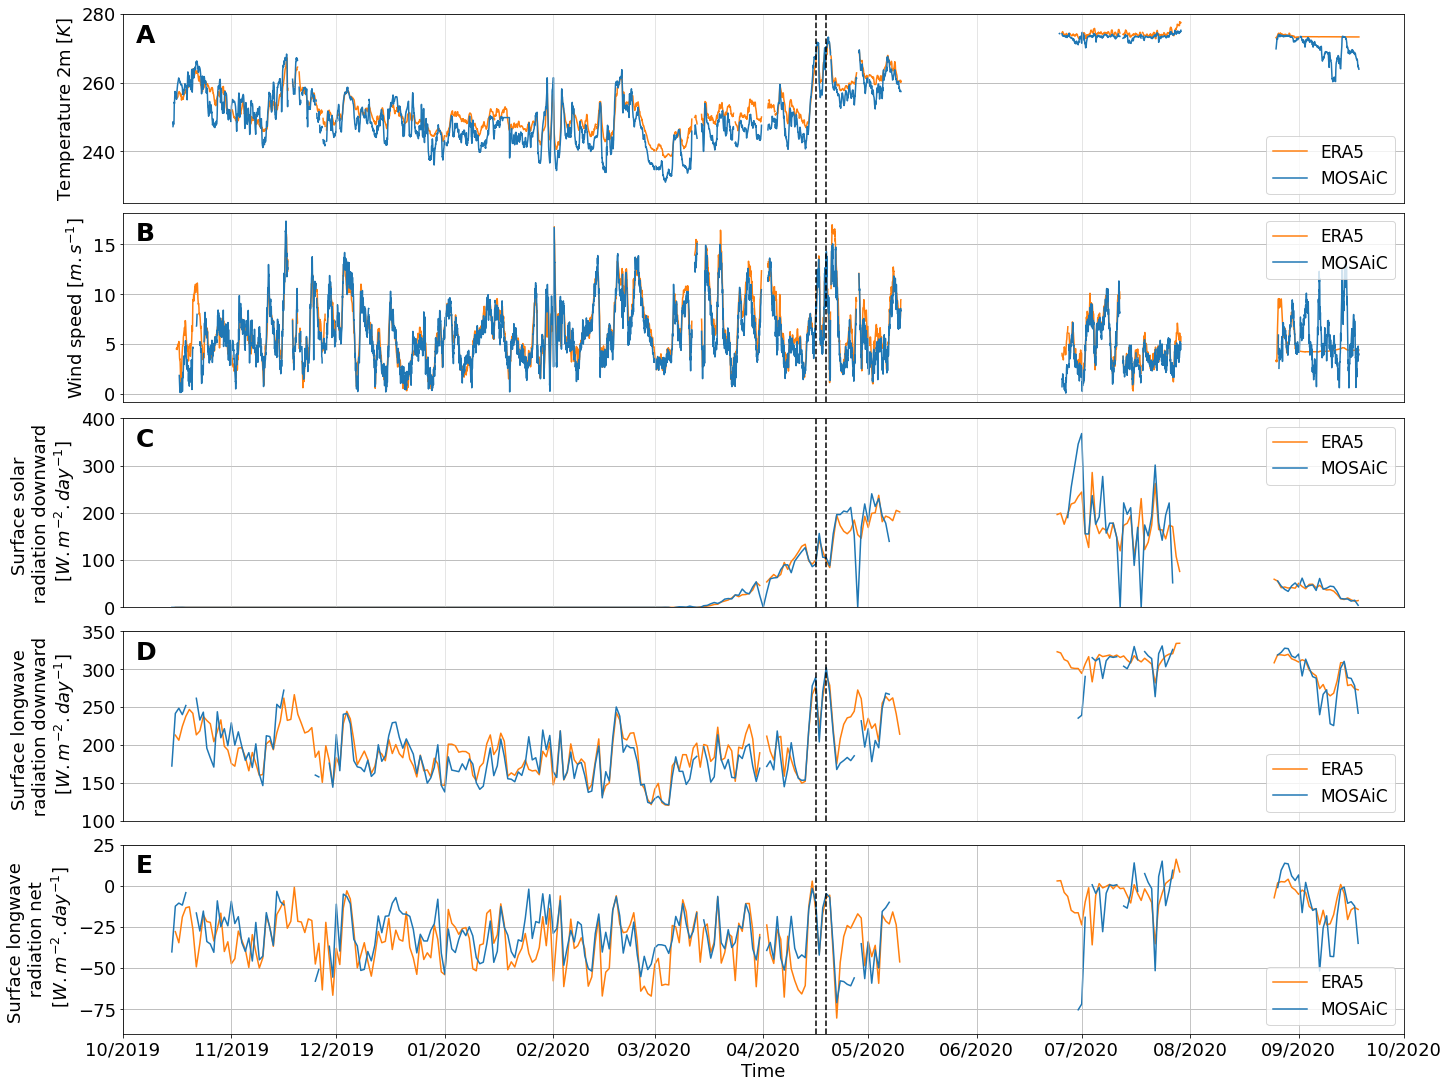

In [29]:
parameters = {'axes.labelsize':18, 'axes.titlesize':18, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
                  'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
nb = 5
fig, axs = plt.subplots(nb,1,figsize=(20,15),gridspec_kw={'height_ratios': [1]*nb}, constrained_layout=True)

axs[0].plot(era5_sfs60.datetime, era5_sfs60.t2m,'-',label='ERA5',color='C1')
axs[0].plot(mosasfs60met_1h.time, mosasfs60met_1h.temp_2m+273.15,'-',label='MOSAiC',color='C0')
axs[0].set_ylabel('Temperature 2m [$K$]')
axs[0].set_ylim(225,280)
axs[0].legend(loc='lower right')
axs[0].text(0.01, 0.85, string.ascii_uppercase[0], transform=axs[0].transAxes, size=25, weight='bold')

axs[1].plot(era5_sfs60.datetime, era5_wspd,'-',label='ERA5',color='C1')
axs[1].plot(mosasfs60met_1h.time, mosaic_wspd, '-',label='MOSAiC',color='C0')
axs[1].set_ylabel('Wind speed [$m.s^{-1}$]')
axs[1].legend(loc='upper right')
axs[1].text(0.01, 0.85, string.ascii_uppercase[1], transform=axs[1].transAxes, size=25, weight='bold')

axs[2].plot(era5_sfs60_daily_mean.index, era5_sfs60_daily_mean.ssrd/3600, '-',label='ERA5',color='C1')
axs[2].plot(mosasfs60met_1h_daily_mean.time, mosasfs60met_1h_daily_mean.down_short_hemisp, '-',label='MOSAiC',color='C0')
axs[2].set_ylabel('Surface solar \n radiation downward \n [$W.m^{-2}.day^{-1}$]')
axs[2].set_ylim(0,400)
axs[2].legend(loc='upper right')
axs[2].text(0.01, 0.85, string.ascii_uppercase[2], transform=axs[2].transAxes, size=25, weight='bold')

axs[3].plot(era5_sfs60_daily_mean.index, era5_sfs60_daily_mean.strd/3600,'-',label='ERA5',color='C1')
axs[3].plot(mosasfs60met_1h_daily_mean.time, mosasfs60met_1h_daily_mean.down_long_hemisp,'-',label='MOSAiC',color='C0')
axs[3].set_ylabel('Surface longwave \n radiation downward \n [$W.m^{-2}.day^{-1}$]')
axs[3].set_ylim(100,350)
axs[3].legend(loc='lower right')
axs[3].text(0.01, 0.85, string.ascii_uppercase[3], transform=axs[3].transAxes, size=25, weight='bold')

axs[4].plot(era5_sfs60_daily_mean.index, era5_sfs60_daily_mean.strd/3600-(era5_sfs60_daily_mean.strd/3600-era5_sfs60_daily_mean.stru/3600),'-',label='ERA5',color='C1')
axs[4].plot(mosasfs60met_1h_daily_mean.time, mosasfs60met_1h_daily_mean.down_long_hemisp-mosasfs60met_1h_daily_mean.up_long_hemisp,'-',label='MOSAiC',color='C0')
axs[4].set_ylabel('Surface longwave \n radiation net \n [$W.m^{-2}.day^{-1}$]')
axs[4].set_ylim(-90,25)
axs[4].legend(loc='lower right')
axs[4].text(0.01, 0.85, string.ascii_uppercase[4], transform=axs[4].transAxes, size=25, weight='bold')
axs[4].xaxis.set_major_formatter(dates.DateFormatter('%m/%Y'))
axs[4].xaxis.set_major_locator(dates.MonthLocator())
axs[4].set_xlabel('Time')

months_date = pd.date_range('2019-09-01','2020-11-01' , freq='1M')-pd.offsets.MonthBegin(1)
for i in range(0,nb) :
    axs[i].axvline(datetime.date(2020, 4, 16), color='k', linestyle='--', linewidth='1.5')
    axs[i].axvline(datetime.date(2020, 4, 19), color='k', linestyle='--', linewidth='1.5')
    axs[i].set_xlim([datetime.date(2019, 10, 1), datetime.date(2020, 10, 1)])
    axs[i].grid()
    for j in range(0,len(months_date)) :
        axs[i].axvline(months_date[j], color='#CCCCCC', linestyle='-', linewidth='0.5')
for i in range(0,nb-1) :
    axs[i].set_xticks([])

path_fig = '/lustre/storeB/users/justinec/master_internship/figures/met_city/'
plt.savefig(path_fig+'MetCity.png',dpi=300, facecolor='white', transparent=False)

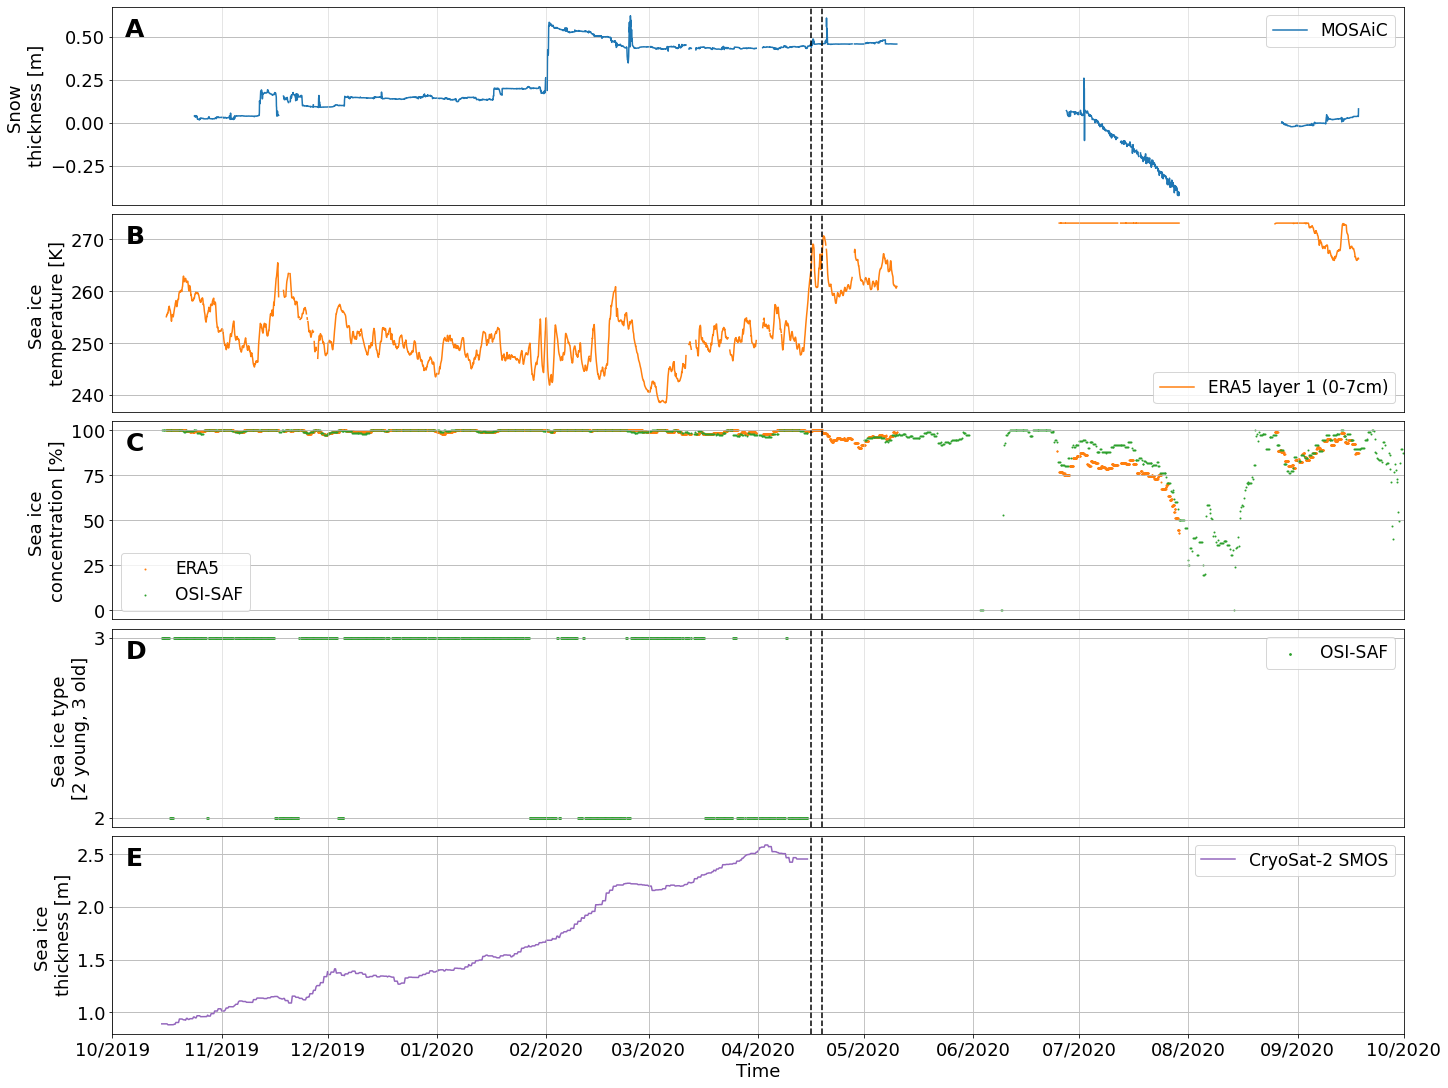

In [145]:
parameters = {'axes.labelsize':18, 'axes.titlesize':18, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
                  'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
nb = 5
fig, axs = plt.subplots(nb,1,figsize=(20,15),gridspec_kw={'height_ratios': [1]*nb}, constrained_layout=True)

axs[0].plot(mosasfs60met_1h.time, mosasfs60met_1h.snow_depth*1e-2,'-',label='MOSAiC',color='C0')
axs[0].set_ylabel('Snow \nthickness [$m$]')
axs[0].text(0.01, 0.85, string.ascii_uppercase[0], transform=axs[0].transAxes, size=25, weight='bold')

axs[1].plot(era5_sfs60.datetime, era5_sfs60.istl,'-',label='ERA5 layer 1 (0-7cm)',color='C1')
axs[1].set_ylabel('Sea ice \ntemperature [$K$]')
axs[1].legend(loc='lower right')
axs[1].text(0.01, 0.85, string.ascii_uppercase[1], transform=axs[1].transAxes, size=25, weight='bold')

axs[2].scatter(era5_sfs60.datetime, era5_sfs60.ci*100,label='ERA5',s=1, color='C1')
axs[2].scatter(df_sea_ice.index, df_sea_ice['sea_ice_concentration_osi[%]'], s=1, color='C2', label='OSI-SAF')
axs[2].set_ylabel('Sea ice \nconcentration [$\%$]')
axs[2].text(0.01, 0.85, string.ascii_uppercase[2], transform=axs[2].transAxes, size=25, weight='bold')

axs[3].scatter(df_sea_ice.index, df_sea_ice['sea_ice_type[2 young, 3 old]'], s=3, color='C2', label='OSI-SAF')
axs[3].set_ylabel('Sea ice type \n[$2 young, 3 old$]')
axs[3].set_yticks([2,3])
axs[3].text(0.01, 0.85, string.ascii_uppercase[3], transform=axs[3].transAxes, size=25, weight='bold')

axs[4].plot(df_sea_ice.index, df_sea_ice['sea_ice_thickness[m]'], 'C4', label='CryoSat-2 SMOS')
axs[4].set_ylabel('Sea ice \nthickness [$m$]')
axs[4].text(0.01, 0.85, string.ascii_uppercase[4], transform=axs[4].transAxes, size=25, weight='bold')
axs[4].xaxis.set_major_formatter(dates.DateFormatter('%m/%Y'))
axs[4].xaxis.set_major_locator(dates.MonthLocator())
axs[4].set_xlabel('Time')

months_date = pd.date_range('2019-09-01','2020-11-01' , freq='1M')-pd.offsets.MonthBegin(1)
for i in range(0,nb) :
    axs[i].axvline(datetime.date(2020, 4, 16), color='k', linestyle='--', linewidth='1.5')
    axs[i].axvline(datetime.date(2020, 4, 19), color='k', linestyle='--', linewidth='1.5')
    axs[i].set_xlim([datetime.date(2019, 10, 1), datetime.date(2020, 10, 1)])
    axs[i].grid()
    for j in range(0,len(months_date)) :
        axs[i].axvline(months_date[j], color='#CCCCCC', linestyle='-', linewidth='0.5')
    if not i == 1 :
        axs[i].legend()
for i in range(0,nb-1) :
    axs[i].set_xticks([])
    
path_fig = '/lustre/storeB/users/justinec/master_internship/figures/met_city/'
plt.savefig(path_fig+'MetCity_sea_ice.png',dpi=300, facecolor='white', transparent=False)

In [119]:
diff_wspd = []
for i in range(0,len(era5_wspd)) :
    diff_wspd.append(era5_wspd[i]-mosaic_wspd[i])
df_diff_wspd = pd.Series(diff_wspd)

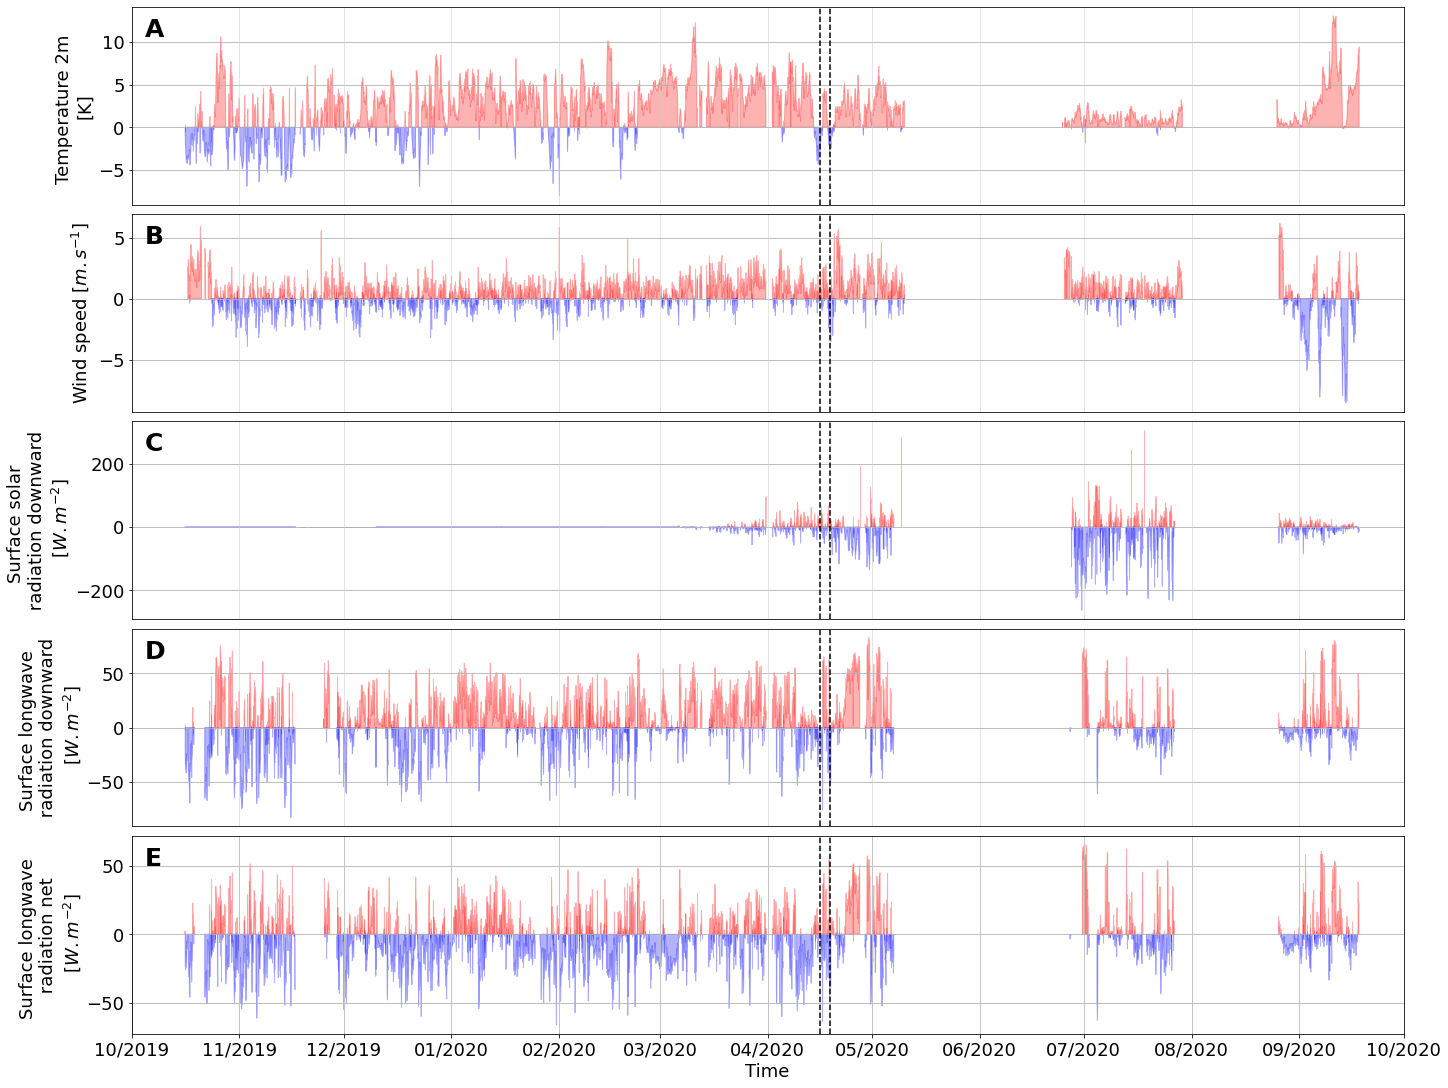

In [143]:
parameters = {'axes.labelsize':18, 'axes.titlesize':18, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
                  'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
nb = 5
fig, axs = plt.subplots(nb,1,figsize=(20,15),gridspec_kw={'height_ratios': [1]*nb}, constrained_layout=True)
plt.rcParams['font.size'] = 12

axs[0].fill_between(era5_sfs60.datetime, 0, era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15), where=(era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15) > 0), color='red', alpha=0.3)
axs[0].fill_between(era5_sfs60.datetime, 0, era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15), where=(era5_sfs60.t2m-(mosasfs60met_1h.temp_2m+273.15) <= 0), color='blue', alpha=0.3)
axs[0].set_ylabel('Temperature 2m \n[$K$]')
axs[0].text(0.01, 0.85, string.ascii_uppercase[0], transform=axs[0].transAxes, size=25, weight='bold')

axs[1].fill_between(era5_sfs60.datetime, 0, df_diff_wspd, where=(df_diff_wspd > 0), color='red', alpha=0.3)
axs[1].fill_between(era5_sfs60.datetime, 0, df_diff_wspd, where=(df_diff_wspd <= 0), color='blue', alpha=0.3)
axs[1].set_ylabel('Wind speed [$m.s^{-1}$]')
axs[1].text(0.01, 0.85, string.ascii_uppercase[1], transform=axs[1].transAxes, size=25, weight='bold')

axs[2].fill_between(era5_sfs60.datetime, 0, era5_sfs60.ssrd/3600-mosasfs60met_1h.down_short_hemisp, where=(era5_sfs60.ssrd/3600-mosasfs60met_1h.down_short_hemisp > 0), color='red', alpha=0.3)
axs[2].fill_between(era5_sfs60.datetime, 0, era5_sfs60.ssrd/3600-mosasfs60met_1h.down_short_hemisp, where=(era5_sfs60.ssrd/3600-mosasfs60met_1h.down_short_hemisp <= 0), color='blue', alpha=0.3)
axs[2].set_ylabel('Surface solar \n radiation downward \n [$W.m^{-2}$]')
axs[2].text(0.01, 0.85, string.ascii_uppercase[2], transform=axs[2].transAxes, size=25, weight='bold')

axs[3].fill_between(era5_sfs60.datetime, 0, era5_sfs60.strd/3600-mosasfs60met_1h.down_long_hemisp, where=(era5_sfs60.strd/3600-mosasfs60met_1h.down_long_hemisp > 0), color='red', alpha=0.3)
axs[3].fill_between(era5_sfs60.datetime, 0, era5_sfs60.strd/3600-mosasfs60met_1h.down_long_hemisp, where=(era5_sfs60.strd/3600-mosasfs60met_1h.down_long_hemisp <= 0), color='blue', alpha=0.3)
axs[3].set_ylabel('Surface longwave \n radiation downward \n [$W.m^{-2}$]')
axs[3].text(0.01, 0.85, string.ascii_uppercase[3], transform=axs[3].transAxes, size=25, weight='bold')

axs[4].fill_between(era5_sfs60.datetime, 0, era5_sfs60.strd/3600-(era5_sfs60.strd/3600-era5_sfs60.stru/3600)-(mosasfs60met_1h.down_long_hemisp-mosasfs60met_1h.up_long_hemisp), where=(era5_sfs60.strd/3600-(era5_sfs60.strd/3600-era5_sfs60.stru/3600)-(mosasfs60met_1h.down_long_hemisp-mosasfs60met_1h.up_long_hemisp) > 0), color='red', alpha=0.3)
axs[4].fill_between(era5_sfs60.datetime, 0, era5_sfs60.strd/3600-(era5_sfs60.strd/3600-era5_sfs60.stru/3600)-(mosasfs60met_1h.down_long_hemisp-mosasfs60met_1h.up_long_hemisp), where=(era5_sfs60.strd/3600-(era5_sfs60.strd/3600-era5_sfs60.stru/3600)-(mosasfs60met_1h.down_long_hemisp-mosasfs60met_1h.up_long_hemisp) <= 0), color='blue', alpha=0.3)
axs[4].set_ylabel('Surface longwave \n radiation net \n [$W.m^{-2}$]')
axs[4].text(0.01, 0.85, string.ascii_uppercase[4], transform=axs[4].transAxes, size=25, weight='bold')
axs[4].set_xlabel('Time')
axs[4].xaxis.set_major_formatter(dates.DateFormatter('%m/%Y'))
axs[4].xaxis.set_major_locator(dates.MonthLocator())
    
months_date = pd.date_range('2019-09-01','2020-11-01' , freq='1M')-pd.offsets.MonthBegin(1)
for i in range(0,nb) :
    axs[i].axvline(datetime.date(2020, 4, 16), color='k', linestyle='--', linewidth='1.5')
    axs[i].axvline(datetime.date(2020, 4, 19), color='k', linestyle='--', linewidth='1.5')
    axs[i].set_xlim([datetime.date(2019, 10, 1), datetime.date(2020, 10, 1)])
    axs[i].grid()
    for j in range(0,len(months_date)) :
        axs[i].axvline(months_date[j], color='#CCCCCC', linestyle='-', linewidth='0.5')
for i in range(0,nb-1) :
    axs[i].set_xticks([])

path_fig = '/lustre/storeB/users/justinec/master_internship/figures/met_city/'
plt.savefig(path_fig+'MetCity_errors.png',dpi=300, facecolor='white', transparent=False)